# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

![GAN diagram](https://github.com/udacity/deep-learning/blob/master/gan_mnist/assets/gan_diagram.png?raw=1)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.

In [1]:
!pip3 uninstall -y tensorflow
!pip3 install tensorflow-gpu==1.15.0

Uninstalling tensorflow-2.2.0:
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 411.5MB 28kB/s 
     |████████████████████████████████| 3.8MB 3.7MB/s 
     |████████████████████████████████| 512kB 31.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=754133be16817aa3bdb36e06f49ce0c0bbe4c0582d3424ac7b7a4339f01370b0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Succes

In [2]:
%matplotlib inline

import pickle as pkl
import numpy as np
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

1.15.0


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, shape=(None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator network

![GAN Network](https://github.com/udacity/deep-learning/blob/master/gan_mnist/assets/gan_network.png?raw=1)



In [0]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer  -> tf.layer.dense does the weight initialization too
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha*h1, h1)

        # 2nd layer
        h2 = tf.layers.dense(h1, n_units, activation=None)
        # Leaky ReLU
        h2 = tf.maximum(alpha*h2, h2)
        
        # Logits and tanh output
        logits = tf.layers.dense(h2, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [0]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha*h1, h1)

        #2nd hidden layer
        h2 = tf.layers.dense(h1, n_units, activation=None)
        # Leaky ReLU
        h2 = tf.maximum(alpha*h2, h2)

        
        logits = tf.layers.dense(h2, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [0]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

In [0]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model = generator(input_z, input_size)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

In [0]:
# Calculate losses
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * ( 1- smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

In [0]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
contents/optimization.html
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [31]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            # Mnist images are  0 to 1 so are rescaling it to pass to the discriminator
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.4450... Generator Loss: 3.3661
Epoch 2/100... Discriminator Loss: 0.6595... Generator Loss: 2.7935
Epoch 3/100... Discriminator Loss: 2.9776... Generator Loss: 0.7140
Epoch 4/100... Discriminator Loss: 0.7901... Generator Loss: 3.8634
Epoch 5/100... Discriminator Loss: 0.6631... Generator Loss: 2.6017
Epoch 6/100... Discriminator Loss: 0.6418... Generator Loss: 3.3462
Epoch 7/100... Discriminator Loss: 0.7752... Generator Loss: 3.4745
Epoch 8/100... Discriminator Loss: 0.7876... Generator Loss: 4.2321
Epoch 9/100... Discriminator Loss: 1.1422... Generator Loss: 2.2112
Epoch 10/100... Discriminator Loss: 0.7372... Generator Loss: 1.8208
Epoch 11/100... Discriminator Loss: 0.5947... Generator Loss: 3.9819
Epoch 12/100... Discriminator Loss: 0.7324... Generator Loss: 1.9189
Epoch 13/100... Discriminator Loss: 0.5817... Generator Loss: 3.3227
Epoch 14/100... Discriminator Loss: 0.5500... Generator Loss: 3.2954
Epoch 15/100... Discriminator Loss: 0.7194.

## Training loss

Here we'll check out the training losses for the generator and discriminator.

In [0]:
%matplotlib inline

import matplotlib.pyplot as pltcontents/optimization.html

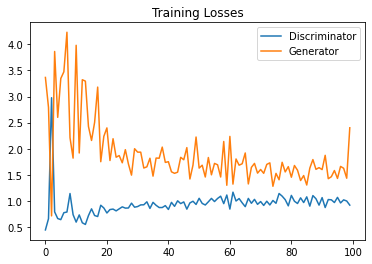

In [33]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [0]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 5, 7, 3, 0, 9. Since this is just a sample, it isn't representative of the full range of images this generator can make.

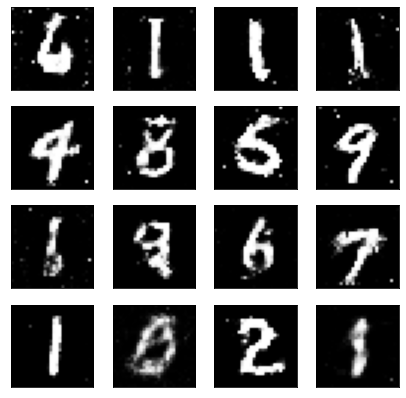

In [37]:
_ = view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs. With bonus optical illusion!

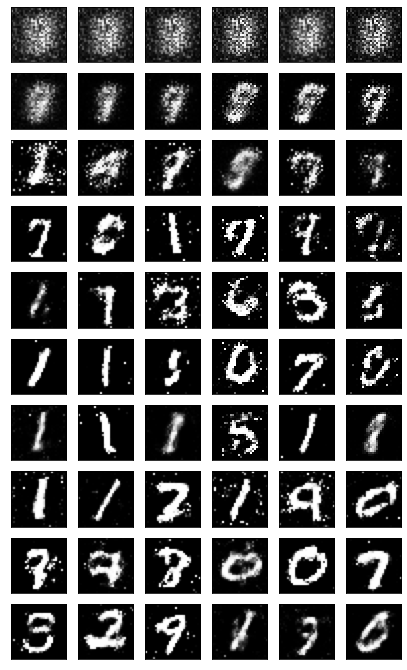

In [38]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise. Looks like 1, 9, and 8 show up first. Then, it learns 5 and 3.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector $z$ and we'll get new samples!

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<Figure size 504x504 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb742ac8c88>,
       dtype=object))

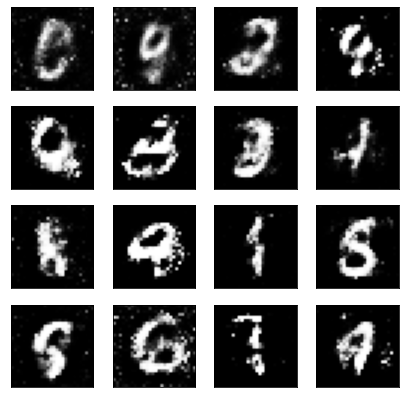

In [24]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])